<a href="https://colab.research.google.com/github/Chidiebere-Ogbuchi/TSP_CausalDiscovery/blob/main/CausalDiscovery_PC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CAUSAL DISCOVERY - PETER CLARK

 * This notebook is used for testing the Peter-Clark Algorithm for Causal Discovery using Py-Why
 * The Peter-Clark Algorithm is a Constraint-Based Algorithm method for inferring causal relationships from observational data.
 * It is commonly used in the field of causal inference and can help identify cause-effect relationships between variables in a dataset.
 * For more information on the Peter-Clark Algorithm and how to get started with causal inference, please refer to the documentation at: [https://causal-learn.readthedocs.io/en/latest/getting_started.html](https://causal-learn.readthedocs.io/en/latest/getting_started.html)


In [1]:
!pip install -r requirement.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 3.8 MB/s eta 0:00:00


In [2]:
import os, time
import sys
sys.path.append("")
import unittest
import hashlib
import numpy as np
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import chisq, fisherz, gsq, kci, mv_fisherz, d_separation
from causallearn.graph.SHD import SHD
from causallearn.utils.DAG2CPDAG import dag2cpdag
from causallearn.utils.TXT2GeneralGraph import txt2generalgraph
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import pickle
# from .utils_simulate_data import simulate_discrete_data, simulate_linear_continuous_data

# or save the graph
from causallearn.utils.GraphUtils import GraphUtils

from causallearn.search.ConstraintBased.PC import pc

### LOADING DATASET

In [5]:
# Load data
def load_data_save_to_txt():
    """
    Load data from either a pickle file or a CSV file and save it to a text file.

    Returns:
        pandas.DataFrame: The loaded data.
    """
    pickle_file_path = "data/test.p"
    csv_file_path = "data/test.csv"
    txt_file_path = 'data/output.txt'

    if os.path.exists(pickle_file_path):
        df = pd.read_pickle(pickle_file_path)
    else:
        df = pd.read_csv(csv_file_path)
        df.to_pickle(pickle_file_path, protocol=pickle.HIGHEST_PROTOCOL)

    df.to_csv(txt_file_path, sep='\t', index=False)

    return df


In [6]:
# View the first few rows of the data
try:
    df = load_data_save_to_txt()
    df.head()
except Exception as e:
    print(f"Csv or Pickle file not found")


Csv or Pickle file not found


In [7]:
## Load data for Causal Discovery from a txt file
def load_txt_dag_data(data_path, num_rows):
    """
    Load data from a text file.

    Args:
        data_path (str): Path to the data file.
        num_rows (int): Number of rows to load from the data file. If None, all rows will be loaded.

    Returns:
        numpy.ndarray: The loaded data as a numpy array.
    """
    full_data = np.loadtxt(data_path, skiprows=1)

    # Select the first num_rows rows
    if num_rows is not None:
        data = full_data[:num_rows, :]
    else:
        data = full_data

    return data

## Load Ground Truth Directed Acyclic Graph (DAG)
def load_truth_dag(truth_graph_path):
    """
    Load the ground truth directed acyclic graph (DAG) from a text file.

    Args:
        truth_graph_path (str): Path to the truth graph file.

    Returns:
        Graph: The loaded truth DAG.
    """
    truth_dag = txt2generalgraph(truth_graph_path)
    return truth_dag

# Usage example:
# Load data
data_path = "data/data_linear_10.txt"   # "output.txt"
truth_graph_path = "data/graph.10.txt"
num_rows = 100  #select number of rows to load or None


data = load_txt_dag_data(data_path, num_rows)
truth_dag = load_truth_dag(truth_graph_path)

### RUNNING ALGORITHM

  0%|          | 0/20 [00:00<?, ?it/s]

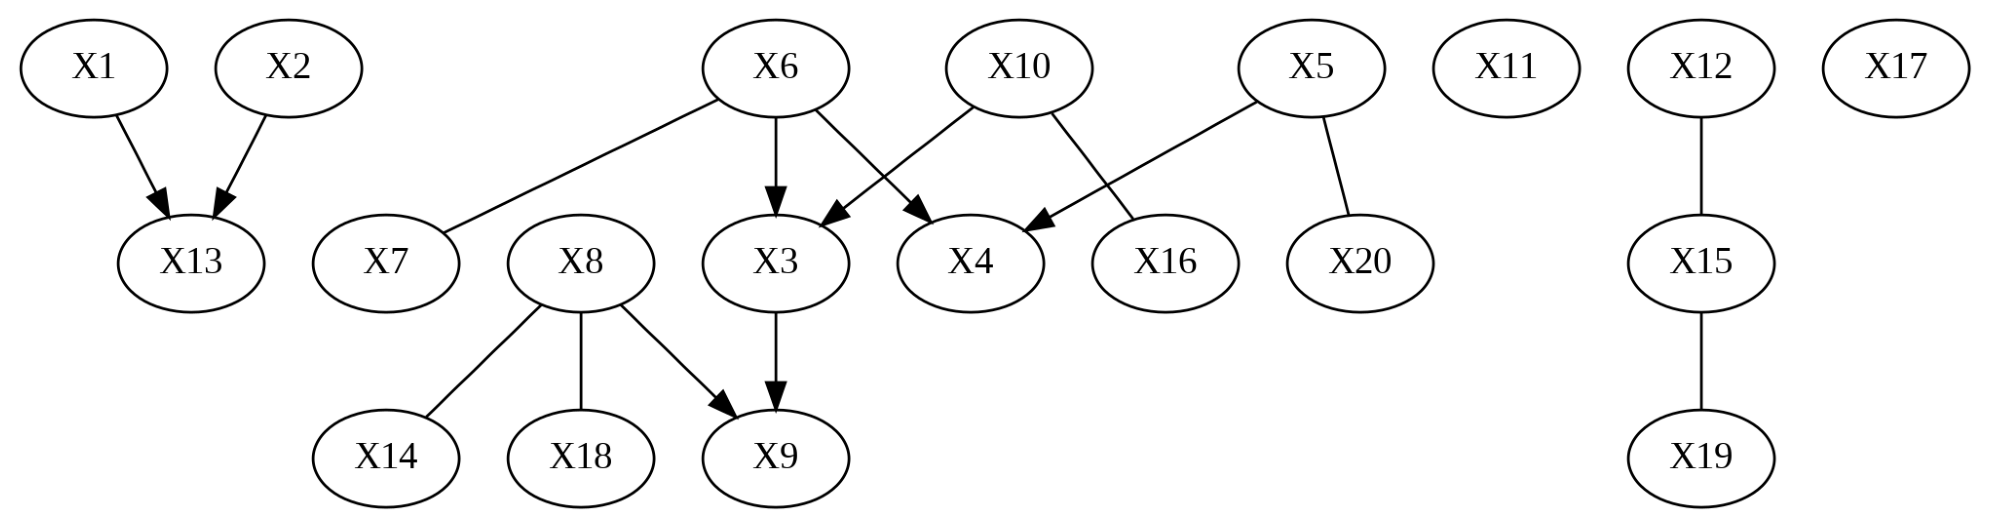

Green: undirected; Blue: directed; Red: bi-directed



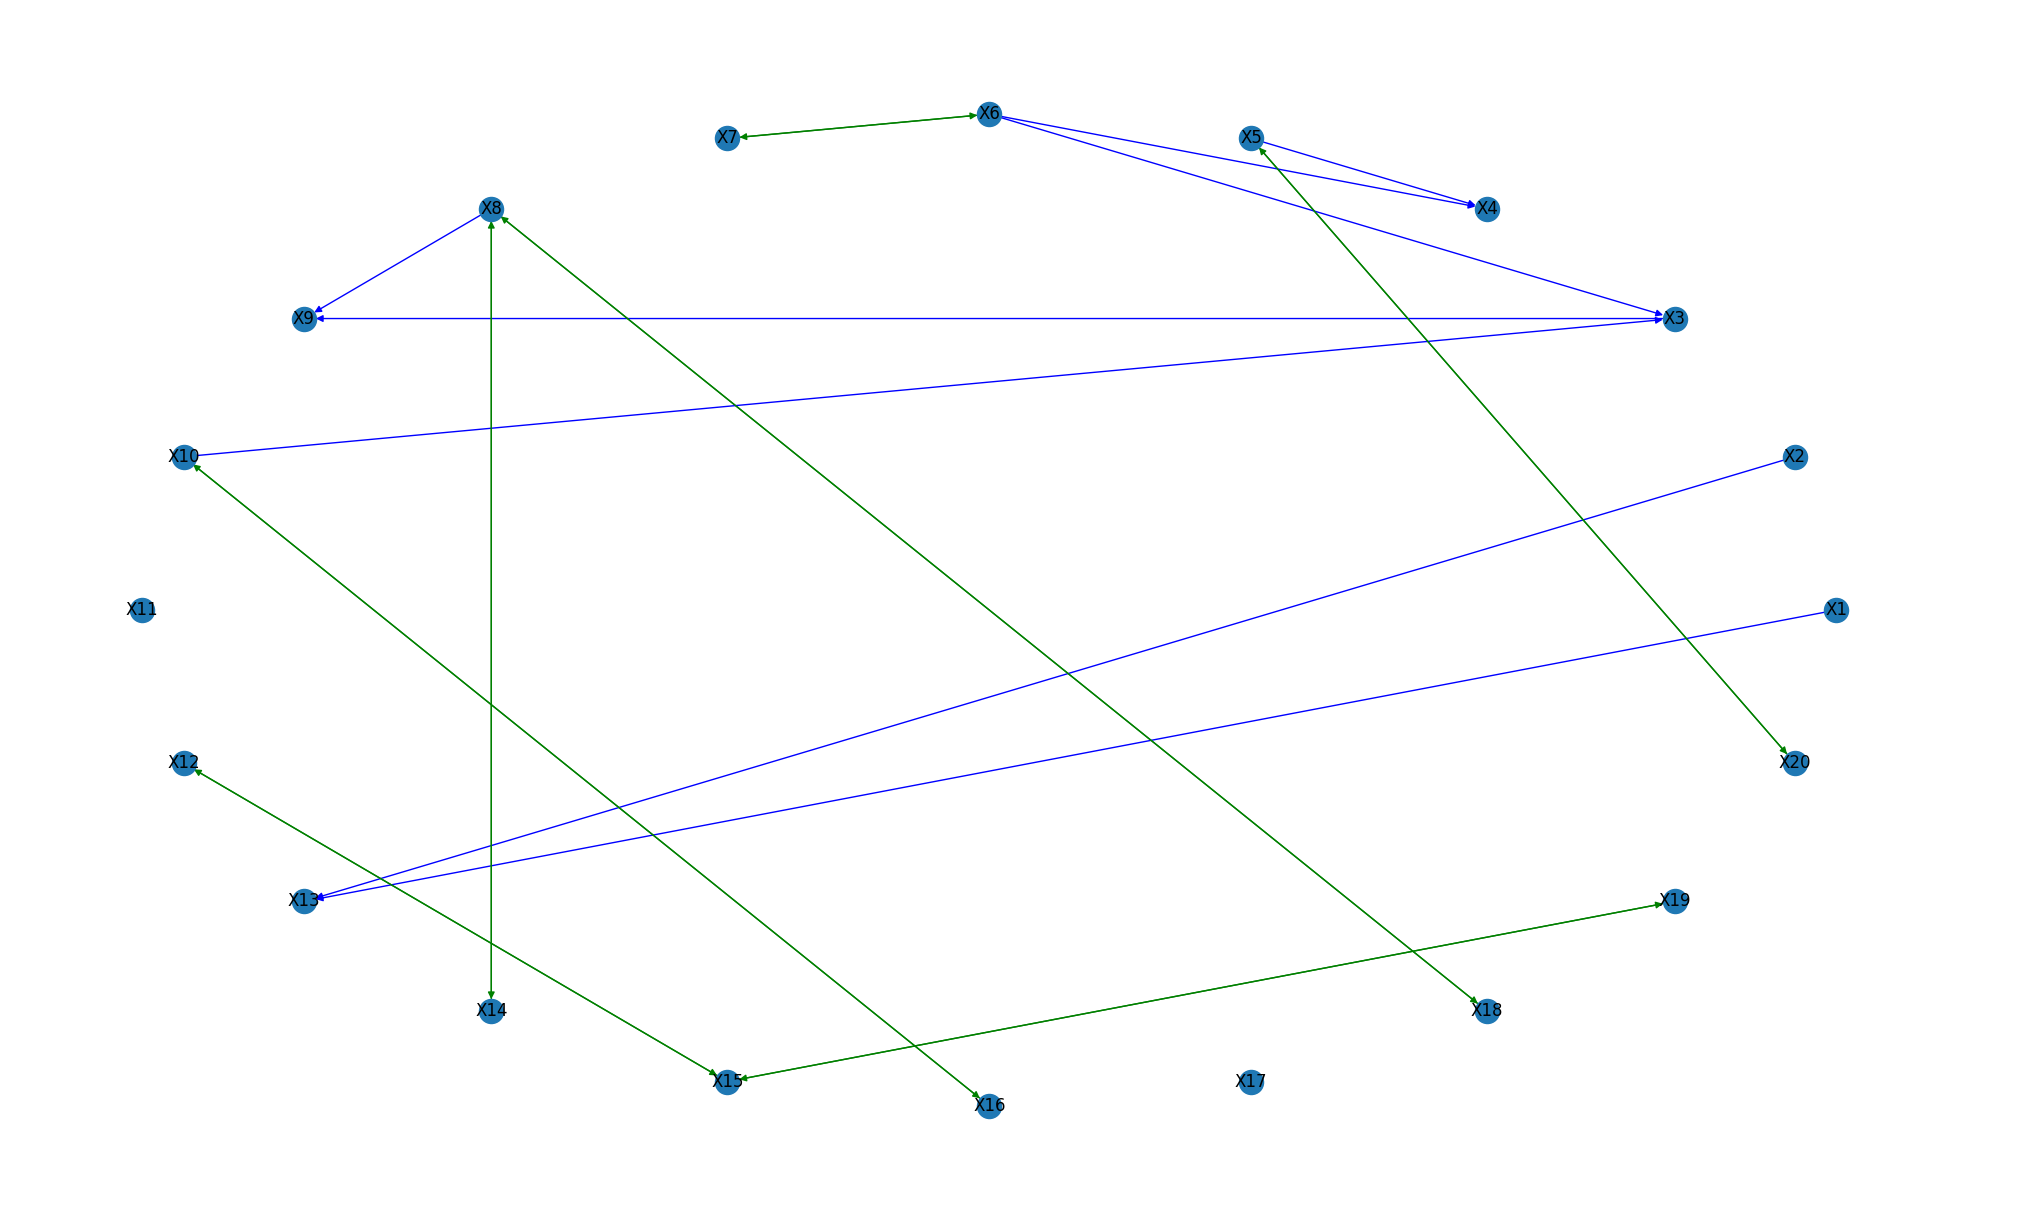

Time taken for PC algorithm: 14.718 seconds


In [16]:
def run_causal_discovery(data):
    """
    Runs the modified PC algorithm for causal discovery on the given data.

    Parameters:
    - data: The input data for causal discovery.
    - alpha: The significance level for conditional independence tests.
    - indep_test: The independence test to use.
        # “fisherz”, “chisq”, “gsq”, “kci”, “mv_fisherz”
    - stable: Whether to use the stable PC algorithm.
    - uc_rule: The unshielded colliders rule to use.
    - uc_priority: The priority of unshielded colliders.
    - mvpc: Whether to use the modified v-structure phase condition.
    - correction_name: The name of the correction to use.
    - background_knowledge: Background knowledge to incorporate in the causal discovery.
    - verbose: Whether to print verbose output.
    - show_progress: Whether to show progress during the algorithm execution.

    Returns:
    - cg: The causal graph object representing the discovered causal relationships.

    Example usage:
    cg = run_causal_discovery(data, 0.05, kci, stable=True, uc_rule='parallel', uc_priority='random', mvpc=True, correction_name='fdr_bh', background_knowledge=None, verbose=True, show_progress=True)
    """
    # cg = pc(data, alpha, indep_test, stable, uc_rule, uc_priority, mvpc, correction_name, background_knowledge, verbose, show_progress)

    # default parameters
    start_time = time.time()

    citest_cache_file = "/cache/citest_cache_dataname_kci.json"    # .json file
    cg = pc(data, 0.05, kci, cache_path=citest_cache_file)             # after the long run

    # visualization using pydot
    cg.draw_pydot_graph()

    # save the graph
    pyd = GraphUtils.to_pydot(cg.G)
    pyd.write_png('simple_test.png')

    # visualization using networkx
    cg.to_nx_graph()
    cg.draw_nx_graph(skel=False)

    end_time = time.time()
    time_taken = round((end_time - start_time), 3)
    print(f"Time taken for PC algorithm: {time_taken} seconds")

    return

# Usage example:
# Run the modified PC algorithm for causal discovery
run_causal_discovery(data)

### Testing Conditional independence Test methods

In [9]:
## Testing Conditional independence Test methods
from causallearn.utils.cit import CIT
mv_fisherz_obj = CIT(data, "fisherz") # construct a CIT instance with data and method name
# “fisherz”, “chisq”, “gsq”, “kci”, “mv_fisherz”
# pValue = mv_fisherz_obj(X, Y, S) # X, Y and condition_set : column indices of data
pValue = mv_fisherz_obj(4, 6, [1, 2])
print(pValue)


0.025028938846096693


In [10]:
## Testing Score Functions
# Local Score BIC
from causallearn.score.LocalScoreFunction import local_score_BIC
i = 6
PAi = [4]
parameters = {"lambda_value": 15}

score = local_score_BIC(data, i, PAi, parameters=parameters)

print(score)

[[307.07757463]]


In [11]:
# Local Score BDEu
from causallearn.score.LocalScoreFunction import local_score_BDeu

i = 6
PAi = [4]

# Set the number of states for the random variables X_i and its parent variables
r_i_map = {i: 2, 4: 3}  # Replace 2 and 3 with the actual number of states for X_i and X_4

# Include the keys in the parameters dictionary with default values
parameters = {"sample_prior": True, "structure_prior": 1.0, "r_i_map": r_i_map}

score = local_score_BDeu(data, i, PAi, parameters)
print(score)


74.90477030960295


In [12]:
# Local Score CV General
from causallearn.score.LocalScoreFunction import local_score_cv_general

# Replace Xi and PAi with the actual values
Xi = 6
PAi = [4]

# Set the parameters
parameters = {"kfold": 5, "lambda": 0.1}

# Call the local_score_cv_general function
score = local_score_cv_general(data, Xi, PAi, parameters)

# Print the result
print(score)


436.5282113042379


In [13]:
### Testing Metrics

In [14]:
## Testing SHD against Truth Graph
print('Now start test_pc_load_linear_10_with_fisher_z ...')
truth_dag = txt2generalgraph(truth_graph_path) # truth_dag is a GeneralGraph instance
truth_cpdag = dag2cpdag(truth_dag)
num_edges_in_truth = truth_dag.get_num_edges()

# Run PC with default parameters: stable=True, uc_rule=0 (uc_sepset), uc_priority=2 (prioritize existing colliders)
cg = pc(data, 0.05, fisherz)  # Run PC and obtain the estimated graph (cg is CausalGraph object)
# benchmark_returned_graph = np.loadtxt("tests/TestData/benchmark_returned_results/linear_10_pc_fisherz_0.05_stable_0_2.txt")
# assert np.all(cg.G.graph == benchmark_returned_graph), INCONSISTENT_RESULT_GRAPH_ERRMSG
shd = SHD(truth_cpdag, cg.G)
print(f"    pc(data, 0.05, fisherz)\tSHD: {shd.get_shd()} of {num_edges_in_truth}")

Now start test_pc_load_linear_10_with_fisher_z ...


  0%|          | 0/20 [00:00<?, ?it/s]

    pc(data, 0.05, fisherz)	SHD: 21 of 30
